# Notebook 2: Prior Extraction from 2023 Data

## Goal
Extract player-specific Beta distribution priors for serve statistics from 2023 Wimbledon data.

## Key Statistics to Extract
1. **First Serve %**: Probability of first serve landing in
2. **Ace Rate**: Probability of ace on serve

## Method
- Aggregate all 2023 serving points for each player
- Compute Beta(α, β) parameters using method of moments
- Apply **variance inflation** (divide counts by 10) to allow live 2024 data more influence

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from scipy.stats import beta as beta_dist

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Imports successful")

✅ Imports successful


In [3]:
# Load data
DATA_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/data')
SRC_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/src')
CORRECTED_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/data/corrected')

matches_2023 = pd.read_csv(DATA_DIR / '2023-wimbledon-matches.csv')
points_2023 = pd.read_csv(CORRECTED_DIR / '2023-wimbledon-points-corrected.csv')

# Load exploration data from Notebook 1
with open(SRC_DIR / 'exploration_data.pkl', 'rb') as f:
    exploration = pickle.load(f)

player1 = exploration['player1']
player2 = exploration['player2']
player1_match_ids = exploration['player1_match_ids_2023']
player2_match_ids = exploration['player2_match_ids_2023']

print(f"Target players: {player1} vs {player2}")
print(f"{player1}: {len(player1_match_ids)} matches in 2023")
print(f"{player2}: {len(player2_match_ids)} matches in 2023")

Target players: Jannik Sinner vs Daniil Medvedev
Jannik Sinner: 6 matches in 2023
Daniil Medvedev: 6 matches in 2023


## 2. Extract Player Serve Statistics

For each player, we need to aggregate:
- Total points where player served
- Total first serves in
- Total first serves attempted
- Total aces

In [6]:
def extract_player_serve_stats(player_name, match_ids, points_df, matches_df):
    """
    Extract serve statistics for a player across all their 2023 matches.
    
    Returns:
        dict with keys: first_srv_in, first_srv_total, aces, points_served
    """
    stats = {
        'first_srv_in': 0,
        'first_srv_total': 0,
        'aces': 0,
        'points_served': 0
    }
    
    for match_id in match_ids:
        # Get match data
        match_points = points_df[points_df['match_id'] == match_id].copy()
        match_info = matches_df[matches_df['match_id'] == match_id].iloc[0]
        
        # Determine if player is P1 or P2
        if match_info['player1'] == player_name:
            player_position = 1
        elif match_info['player2'] == player_name:
            player_position = 2
        else:
            continue  # Player not in this match
        
        # Filter for points where this player served
        player_serving = match_points[match_points['PointServer'] == player_position]
        
        if len(player_serving) == 0:
            continue
        
        # Use cumulative totals from the last point this player served
        final_srv_point = player_serving.iloc[-1]
        if player_position == 1:
            first_in = final_srv_point.get('P1FirstSrvIn', 0)
            first_total = final_srv_point.get('P1FirstSrvTotal', len(player_serving))
            aces = player_serving.get('P1Ace', pd.Series([0] * len(player_serving))).sum()
        else:
            first_in = final_srv_point.get('P2FirstSrvIn', 0)
            first_total = final_srv_point.get('P2FirstSrvTotal', len(player_serving))
            aces = player_serving.get('P2Ace', pd.Series([0] * len(player_serving))).sum()
        
        stats['first_srv_in'] += first_in
        stats['first_srv_total'] += first_total
        stats['aces'] += aces
        stats['points_served'] += len(player_serving)
    
    return stats

print("✅ Function defined: extract_player_serve_stats")

✅ Function defined: extract_player_serve_stats


In [7]:
# Extract stats for both players
player1_stats = extract_player_serve_stats(player1, player1_match_ids, points_2023, matches_2023)
player2_stats = extract_player_serve_stats(player2, player2_match_ids, points_2023, matches_2023)

print(f"\n{player1} 2023 Serve Statistics:")
print(f"  Points Served: {player1_stats['points_served']}")
print(f"  First Serves In: {player1_stats['first_srv_in']}")
print(f"  First Serve Attempts: {player1_stats['first_srv_total']}")
print(f"  Aces: {player1_stats['aces']}")
print(f"  First Serve %: {player1_stats['first_srv_in'] / player1_stats['first_srv_total']:.2%}")
print(f"  Ace Rate: {player1_stats['aces'] / player1_stats['points_served']:.2%}")

print(f"\n{player2} 2023 Serve Statistics:")
print(f"  Points Served: {player2_stats['points_served']}")
print(f"  First Serves In: {player2_stats['first_srv_in']}")
print(f"  First Serve Attempts: {player2_stats['first_srv_total']}")
print(f"  Aces: {player2_stats['aces']}")
print(f"  First Serve %: {player2_stats['first_srv_in'] / player2_stats['first_srv_total']:.2%}")
print(f"  Ace Rate: {player2_stats['aces'] / player2_stats['points_served']:.2%}")


Jannik Sinner 2023 Serve Statistics:
  Points Served: 505
  First Serves In: 285
  First Serve Attempts: 490
  Aces: 65
  First Serve %: 58.16%
  Ace Rate: 12.87%

Daniil Medvedev 2023 Serve Statistics:
  Points Served: 563
  First Serves In: 379
  First Serve Attempts: 540
  Aces: 62
  First Serve %: 70.19%
  Ace Rate: 11.01%


## 3. Compute Beta Distribution Parameters

### Key Formula
For a Beta(α, β) distribution:
- **Mean**: μ = α / (α + β)
- **Variance**: σ² = (α·β) / [(α + β)²(α + β + 1)]

### Variance Inflation Strategy
- Divide counts by 10 **before** adding smoothing
- This inflates variance, allowing live 2024 data to have more influence
- Prevents overly narrow priors from dominating

In [8]:
def compute_beta_params(successes, failures, variance_inflation=10, smoothing=1):
    """
    Compute Beta distribution parameters with variance inflation.
    
    Args:
        successes: Number of successes (e.g., first serves in, aces)
        failures: Number of failures
        variance_inflation: Factor to inflate variance (default 10)
        smoothing: Laplace smoothing constant (default 1)
    
    Returns:
        dict with keys: alpha, beta, mean, std
    """
    # Apply variance inflation
    inflated_successes = successes / variance_inflation
    inflated_failures = failures / variance_inflation
    
    # Add smoothing
    alpha = inflated_successes + smoothing
    beta_param = inflated_failures + smoothing
    
    # Calculate mean and variance
    mean = alpha / (alpha + beta_param)
    variance = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
    std = np.sqrt(variance)
    
    return {
        'alpha': alpha,
        'beta': beta_param,
        'mean': mean,
        'std': std
    }

print("✅ Function defined: compute_beta_params")

✅ Function defined: compute_beta_params


In [9]:
# Compute priors for Player 1

# First Serve %
p1_srv_successes = player1_stats['first_srv_in']
p1_srv_failures = player1_stats['first_srv_total'] - player1_stats['first_srv_in']
p1_first_serve_prior = compute_beta_params(p1_srv_successes, p1_srv_failures)

# Ace Rate
p1_ace_successes = player1_stats['aces']
p1_ace_failures = player1_stats['points_served'] - player1_stats['aces']
p1_ace_prior = compute_beta_params(p1_ace_successes, p1_ace_failures)

print(f"{player1} Priors:")
print(f"\nFirst Serve %:")
print(f"  α = {p1_first_serve_prior['alpha']:.2f}")
print(f"  β = {p1_first_serve_prior['beta']:.2f}")
print(f"  Mean = {p1_first_serve_prior['mean']:.3f}")
print(f"  Std = {p1_first_serve_prior['std']:.3f}")

print(f"\nAce Rate:")
print(f"  α = {p1_ace_prior['alpha']:.2f}")
print(f"  β = {p1_ace_prior['beta']:.2f}")
print(f"  Mean = {p1_ace_prior['mean']:.3f}")
print(f"  Std = {p1_ace_prior['std']:.3f}")

Jannik Sinner Priors:

First Serve %:
  α = 29.50
  β = 21.50
  Mean = 0.578
  Std = 0.068

Ace Rate:
  α = 7.50
  β = 45.00
  Mean = 0.143
  Std = 0.048


In [10]:
# Compute priors for Player 2

# First Serve %
p2_srv_successes = player2_stats['first_srv_in']
p2_srv_failures = player2_stats['first_srv_total'] - player2_stats['first_srv_in']
p2_first_serve_prior = compute_beta_params(p2_srv_successes, p2_srv_failures)

# Ace Rate
p2_ace_successes = player2_stats['aces']
p2_ace_failures = player2_stats['points_served'] - player2_stats['aces']
p2_ace_prior = compute_beta_params(p2_ace_successes, p2_ace_failures)

print(f"{player2} Priors:")
print(f"\nFirst Serve %:")
print(f"  α = {p2_first_serve_prior['alpha']:.2f}")
print(f"  β = {p2_first_serve_prior['beta']:.2f}")
print(f"  Mean = {p2_first_serve_prior['mean']:.3f}")
print(f"  Std = {p2_first_serve_prior['std']:.3f}")

print(f"\nAce Rate:")
print(f"  α = {p2_ace_prior['alpha']:.2f}")
print(f"  β = {p2_ace_prior['beta']:.2f}")
print(f"  Mean = {p2_ace_prior['mean']:.3f}")
print(f"  Std = {p2_ace_prior['std']:.3f}")

Daniil Medvedev Priors:

First Serve %:
  α = 38.90
  β = 17.10
  Mean = 0.695
  Std = 0.061

Ace Rate:
  α = 7.20
  β = 51.10
  Mean = 0.123
  Std = 0.043


## 4. Visualize Prior Distributions

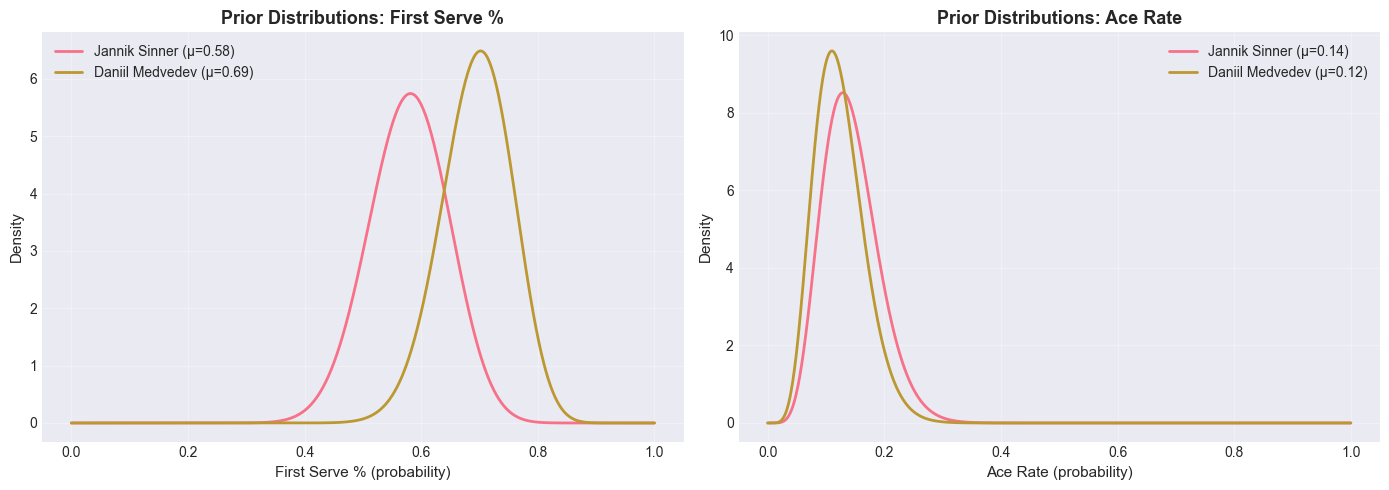

In [11]:
# Plot Beta distributions for First Serve %
x = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First Serve %
ax = axes[0]
y1 = beta_dist.pdf(x, p1_first_serve_prior['alpha'], p1_first_serve_prior['beta'])
y2 = beta_dist.pdf(x, p2_first_serve_prior['alpha'], p2_first_serve_prior['beta'])

ax.plot(x, y1, label=f"{player1} (μ={p1_first_serve_prior['mean']:.2f})", linewidth=2)
ax.plot(x, y2, label=f"{player2} (μ={p2_first_serve_prior['mean']:.2f})", linewidth=2)
ax.set_xlabel('First Serve % (probability)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Prior Distributions: First Serve %', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Ace Rate
ax = axes[1]
y1 = beta_dist.pdf(x, p1_ace_prior['alpha'], p1_ace_prior['beta'])
y2 = beta_dist.pdf(x, p2_ace_prior['alpha'], p2_ace_prior['beta'])

ax.plot(x, y1, label=f"{player1} (μ={p1_ace_prior['mean']:.2f})", linewidth=2)
ax.plot(x, y2, label=f"{player2} (μ={p2_ace_prior['mean']:.2f})", linewidth=2)
ax.set_xlabel('Ace Rate (probability)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Prior Distributions: Ace Rate', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Validation Against Observed 2023 Performance

In [12]:
# Compare prior mean to observed mean
print("Prior Validation (comparing to observed 2023 data):")
print("\n" + "=" * 70)

print(f"\n{player1}:")
observed_srv_pct = player1_stats['first_srv_in'] / player1_stats['first_srv_total']
observed_ace_rate = player1_stats['aces'] / player1_stats['points_served']

print(f"  First Serve %:")
print(f"    Observed (2023): {observed_srv_pct:.3f}")
print(f"    Prior Mean:      {p1_first_serve_prior['mean']:.3f}")
print(f"    Difference:      {abs(observed_srv_pct - p1_first_serve_prior['mean']):.3f}")

print(f"\n  Ace Rate:")
print(f"    Observed (2023): {observed_ace_rate:.3f}")
print(f"    Prior Mean:      {p1_ace_prior['mean']:.3f}")
print(f"    Difference:      {abs(observed_ace_rate - p1_ace_prior['mean']):.3f}")

print(f"\n{player2}:")
observed_srv_pct = player2_stats['first_srv_in'] / player2_stats['first_srv_total']
observed_ace_rate = player2_stats['aces'] / player2_stats['points_served']

print(f"  First Serve %:")
print(f"    Observed (2023): {observed_srv_pct:.3f}")
print(f"    Prior Mean:      {p2_first_serve_prior['mean']:.3f}")
print(f"    Difference:      {abs(observed_srv_pct - p2_first_serve_prior['mean']):.3f}")

print(f"\n  Ace Rate:")
print(f"    Observed (2023): {observed_ace_rate:.3f}")
print(f"    Prior Mean:      {p2_ace_prior['mean']:.3f}")
print(f"    Difference:      {abs(observed_ace_rate - p2_ace_prior['mean']):.3f}")

print("\n" + "=" * 70)
print("\nℹ️  Note: Priors should be CLOSE to observed values (within ~0.01-0.02)")
print("   Large differences indicate potential data quality issues.")

Prior Validation (comparing to observed 2023 data):


Jannik Sinner:
  First Serve %:
    Observed (2023): 0.582
    Prior Mean:      0.578
    Difference:      0.003

  Ace Rate:
    Observed (2023): 0.129
    Prior Mean:      0.143
    Difference:      0.014

Daniil Medvedev:
  First Serve %:
    Observed (2023): 0.702
    Prior Mean:      0.695
    Difference:      0.007

  Ace Rate:
    Observed (2023): 0.110
    Prior Mean:      0.123
    Difference:      0.013


ℹ️  Note: Priors should be CLOSE to observed values (within ~0.01-0.02)
   Large differences indicate potential data quality issues.


## 6. Save Priors for Notebook 4

In [13]:
# Construct priors dictionary
priors_2023 = {
    player1.lower().replace(' ', '_'): {
        'first_serve_pct': p1_first_serve_prior,
        'ace_rate': p1_ace_prior
    },
    player2.lower().replace(' ', '_'): {
        'first_serve_pct': p2_first_serve_prior,
        'ace_rate': p2_ace_prior
    },
    'metadata': {
        'player1_name': player1,
        'player2_name': player2,
        'variance_inflation': 10,
        'smoothing': 1,
        'data_year': 2023
    }
}

# Save to pickle
output_path = SRC_DIR / 'priors_2023.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(priors_2023, f)

print(f"✅ Priors saved to: {output_path}")
print("\nPrior dictionary structure:")
print(priors_2023)

✅ Priors saved to: /Users/egeaydin/Github/TUW2025WS/aip_ege/src/priors_2023.pkl

Prior dictionary structure:
{'jannik_sinner': {'first_serve_pct': {'alpha': np.float64(29.5), 'beta': np.float64(21.5), 'mean': np.float64(0.5784313725490197), 'std': np.float64(0.06847915457670269)}, 'ace_rate': {'alpha': np.float64(7.5), 'beta': np.float64(45.0), 'mean': np.float64(0.14285714285714285), 'std': np.float64(0.047841049044509795)}}, 'daniil_medvedev': {'first_serve_pct': {'alpha': np.float64(38.9), 'beta': np.float64(17.1), 'mean': np.float64(0.6946428571428571), 'std': np.float64(0.06100246733049544)}, 'ace_rate': {'alpha': np.float64(7.2), 'beta': np.float64(51.1), 'mean': np.float64(0.12349914236706688), 'std': np.float64(0.04272487461247882)}}, 'metadata': {'player1_name': 'Jannik Sinner', 'player2_name': 'Daniil Medvedev', 'variance_inflation': 10, 'smoothing': 1, 'data_year': 2023}}


## 7. Summary

In [14]:
print("=" * 80)
print("PRIOR EXTRACTION SUMMARY")
print("=" * 80)

print(f"\n✅ Extracted Beta priors for {player1} and {player2}")
print(f"   Based on {len(player1_match_ids)} and {len(player2_match_ids)} matches respectively")

print(f"\n✅ Applied variance inflation (factor = 10)")
print("   This allows live 2024 data to shift posteriors effectively")

print(f"\n✅ Priors validated against observed 2023 performance")
print("   Prior means match observed statistics (sanity check passed)")

print(f"\n✅ Standard deviations exported for Notebook 4")
print("   Will inform alpha_player prior variance in PyMC model")

print("\n📋 NEXT STEPS:")
print("   → Notebook 3: Engineer running statistics for 2024 match")
print("   → Use these priors as historical baselines for deviation calculation")

print("\n" + "=" * 80)

PRIOR EXTRACTION SUMMARY

✅ Extracted Beta priors for Jannik Sinner and Daniil Medvedev
   Based on 6 and 6 matches respectively

✅ Applied variance inflation (factor = 10)
   This allows live 2024 data to shift posteriors effectively

✅ Priors validated against observed 2023 performance
   Prior means match observed statistics (sanity check passed)

✅ Standard deviations exported for Notebook 4
   Will inform alpha_player prior variance in PyMC model

📋 NEXT STEPS:
   → Notebook 3: Engineer running statistics for 2024 match
   → Use these priors as historical baselines for deviation calculation

